# Exploring ECCC prediction products with the MSC's Geospatial Web Services

During this tutorial we'll explore the mechanics of retrieving prediction data from ECCC's Meteorological Service of Canada (MSC). We'll take a close look at three geospatial web services, the Web Map Service (WMS), the Web Coverage Service (WCS), and the Open Geospatial Consortium's (OGC) Features API. All three of these web services are application programming interfaces that allow us to "talk with" and receive data from the MSC's GeoMet service. In this tutorial we'll focus on retrieving precipitation analysis predictions and observed precipitation accumulations, but the "recipes" below apply to any datasets available from MSC's GeoMet. 

It's important to note that the code that we'll explore here is analagous to the code that your FEWS system uses to retreive data from the MSC. As such, the goals for this tutorial are to give you a sense of what is going on "under the hood" of your FEWS system and to familiarize you with the terminology and process of retrieving data from the MSC's geospatial web services. By the end of this tutorial you will understand how scripts can be used to retrieve images / data from the MSC and how these scripts can be used to manipulate raw prediction data to create maps and plots. Given that your FEWS system does the work of the code shown in this tutorial, it's not necessary to understand the minutae of the Python code blocks below. Rather, this tutorial is intended to provide you with general background information that you may find helpful when having technical discussions with your industry partners. The information in this tutorial may also prove useful for exploring MSC data further, and for the technically savvy, this tutorial can be a jumping off point for writing or contributing to related code.

Finally, it's worth noting that your FEWS system likely fetches the majority of data from GeoMet's sister service, Datamart. Unfortunately, we won't explore Datamart during this tutorial for technical reasons (the data retrieval mechanism is hard to use in a "lightweight" tutorial like this, especially with conference centre WiFi!). However, the mechanics and process of querying for data from the two services is similar and the differences are not important for the purposes of this tutorial.


## Setting things up

In [1]:
# @title Downloading tutorial requirements into this Colab instance

# The following `%%capture` command will hide a bunch of text that gets
# generated when we install the following libraries
%%capture
!pip install owslib
!pip install cartopy
!pip install panel hvplot jupyter_bokeh

In [2]:
# @title Setting up plotting environment
import holoviews as hv
import hvplot.pandas
import panel as pn
pn.extension()

if 'google.colab' in str(get_ipython()):
    def _render(self, **kw):
        hv.extension('bokeh')
        return hv.Store.render(self)
    hv.core.Dimensioned._repr_mimebundle_ = _render

In [30]:
# @title Importing tutorial requirements

# Tools for handling data
import re
import warnings
import xarray as xr
import pandas as pd
import geopandas as gpd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
from datetime import datetime, timedelta

# Tools that will help us connect to GeoMet's geospatial web services
from owslib.wms import WebMapService
from owslib.wcs import WebCoverageService
from owslib.wcs import Authentication
from owslib.ogcapi.features import Features
from owslib.ogcapi.coverages import Coverages

# Plotting tools
import cartopy.crs as ccrs
import cartopy.feature as cf
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import cm
from matplotlib.animation import FuncAnimation
from matplotlib.gridspec import GridSpec
from IPython.display import Image, display, clear_output
import hvplot.xarray

from matplotlib import rc
rc('animation', html='jshtml')

# Here we'll set up a filter so we don't see a bunch of warnings
warnings.filterwarnings('ignore')

In this tutorial we'll be viewing prediction data from the MSC's geospatial web services. This will involve making queries for data from a specific location in Canada. We'll define our location using a bounding box and we'll center our bounding box on a location of interest. You're welcome to center your bounding box on a location of your choosing, like your favourite gauge station, your office, your go-to camping spot, etc.

To generate your bounding box, replace the values for the `lat` and `lon` variables below. To get the lat / lon coordinates of your place of interest, you can use this website: https://www.latlong.net/convert-address-to-lat-long.html

In [6]:
# @title Setting our location of interest

# Lat / Lon coords for place of interest
lat = 45.48
lon = -73.79

# We'll make our bounding box 5 x 5 degrees
buffer = 5

# Bounding box for the Web Map Service
bbox_wms = (lon-buffer, lat-buffer*0.5, lon+buffer, lat+buffer*0.5)

# Subset (bounding box) for the Web Coverage Service
bbox_wcs = [('lat', lat-buffer, lat+buffer), ('lon', lon-buffer, lon+buffer)]

## Viewing current precipitation using GeoMet's Web Map Service

First, we'll start by creating an object, `wms` that will allow us to connect to GeoMet's web map service (WMS). 

In [7]:
# @title Creating a connection to the WMS

# Create a connector object to query the Web Map Service
wms = WebMapService(
    f'https://geo.weather.gc.ca/geomet?&SERVICE=WMS',
    version='1.3.0',
    timeout=300
)

Next, we'll query for a map image from the High Resolution Determinisitic Precipitation Analysis (HRDPA). But before we can do that, we'll need to gather the information we need to construct our query. We can get this information from two places, 1) the WMS documentation and 2) our `wms` connection object. Starting with the WMS documentation we know we'll need the following info:

- the name of the HRDPA layer
- the style of the layer, or in other words, the colorbar for the map image
- the format we'd like to receive the data in
- the coordinate reference system that the data should be projected onto
- the bounding box that the WMS will use to cut out the subset of the grid we're interested in

From the documentation, we can see that to get a map image, we'll need to specify the data format as `image/jpeg` and we can use the default coordinate reference system, `EPSG:4326`. We defined our bounding box above, so that leaves the layer name and layer style for us to find. To get this information, we'll need to poke around with the `wms` connection object, or we can view the layer on AniMet.

Let's explore the metadata with the `wms` connection object. First, we'll print all the available layers that contain the word `HRDPA`.

In [8]:
# Print HRDPA layer names from the WMS connector
for layer_name in wms.contents.keys():
  if 'HRDPA' in layer_name:
    print(layer_name)

High Resolution Deterministic Precipitation Analysis (HRDPA) [2.5 km]
HRDPA-Prelim_2.5km_Precip-Accum6h
HRDPA-Prelim_2.5km_Precip-Accum24h-T06Z
HRDPA-Prelim_2.5km_Precip-Accum24h-T12Z
HRDPA.6F_PR
HRDPA.06F_WATERSHED
HRDPA.6P_PR
HRDPA.06P_WATERSHED
HRDPA.24F_PR
HRDPA.24F_WATERSHED
HRDPA.24P_PR
HRDPA.24P_WATERSHED
HRDPA_2.5km_Precip-Accum6h
HRDPA_2.5km_Precip-Accum24h-T06Z
HRDPA_2.5km_Precip-Accum24h-T12Z


Some of these layer names look a bit cryptic. We can choose to print a layer's title, which should give us a better indication of what the layer contains. For the first part of this tutorial, we'll explore the `HRDPA.6F_PR` layer.

In [9]:
# The layer we're going to query in this section
layer = 'HRDPA.6F_PR'

In [10]:
# Check the layer title for additional detail
wms[layer].title

'HRDPA.06F - Quantity of precipitation [mm]'

Now let's look for the available colourbars (layer styles) we can use for the map image.

In [11]:
# Check out the colourmap options for our layer
for style, details in wms[layer].styles.items():
  print(
      f"Style name: {style} \n Link: {details['legend']}"
  )

Style name: CAPA24-LINEAR 
 Link: https://geo.weather.gc.ca/geomet?version=1.3.0&service=WMS&request=GetLegendGraphic&sld_version=1.1.0&layer=HRDPA.6F_PR&format=image/png&STYLE=CAPA24-LINEAR
Style name: PRECIPMM 
 Link: https://geo.weather.gc.ca/geomet?version=1.3.0&service=WMS&request=GetLegendGraphic&sld_version=1.1.0&layer=HRDPA.6F_PR&format=image/png&STYLE=PRECIPMM
Style name: PRECIPMM-LINEAR 
 Link: https://geo.weather.gc.ca/geomet?version=1.3.0&service=WMS&request=GetLegendGraphic&sld_version=1.1.0&layer=HRDPA.6F_PR&format=image/png&STYLE=PRECIPMM-LINEAR
Style name: CAPA24 
 Link: https://geo.weather.gc.ca/geomet?version=1.3.0&service=WMS&request=GetLegendGraphic&sld_version=1.1.0&layer=HRDPA.6F_PR&format=image/png&STYLE=CAPA24
Style name: RDPA-WXO 
 Link: https://geo.weather.gc.ca/geomet?version=1.3.0&service=WMS&request=GetLegendGraphic&sld_version=1.1.0&layer=HRDPA.6F_PR&format=image/png&STYLE=RDPA-WXO
Style name: Precip-Accum_0-1000mm_Dis 
 Link: https://geo.weather.gc.ca/geo

In [12]:
# The default colourmap that we're going to specify for our layer
hrdpa_style = 'RDPA-WXO'

Now we have the minimum information necessary to make a query. Let's make a query for a map image using the `wms` object and then we'll use Python's `Image` function to parse the information from the query and display the map. 

To get our requested information, the `wms` object takes our query parameters and formats them into a URL. The `wms` object URL tells GeoMet what information it should prepare for us. Then, the `wms` object requests the information that GeoMet prepared.

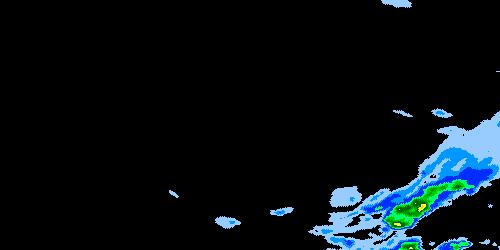

In [13]:
# @title Making a map query

width = 500
height = 250

# Querying the WMS for a subset of our layer defined by our bounding box
response = wms.getmap(
    layers=[layer],
    format='image/jpeg',
    srs='EPSG:4326',
    bbox=bbox_wms,
    size=(width, height), # this defines the size of the map image
    styles=[hrdpa_style],
)

# Show image
Image(response.read(), width=width, height=height)

Et voila! Precipitation accumulations should show up as colours on a black background. If you only see a black image, this is normal - it just means there isn't any accumulated precipitation in your bounding box for the timestep returned from the query (more on time in a moment...) 

Now that we've made our first query, let's have a look at the query URL.

In [14]:
# The raw HTML for our WMS query
response.geturl()

'https://geo.weather.gc.ca/geomet?service=WMS&version=1.3.0&request=GetMap&layers=HRDPA.6F_PR&styles=RDPA-WXO&width=500&height=250&crs=EPSG%3A4326&bbox=42.983372%2C-78.787933%2C47.983372%2C-68.787933&format=image%2Fjpeg&transparent=FALSE&exceptions=XML&bgcolor=0xFFFFFF'

Just like the `wms` object, your FEWS system would use an analogous process to construct URLS and query GeoMet. The code that we're playing around with here is similar to the code "under the hood" of your FEWS system.

Let's explore some other aspects of making queries to GeoMet. Previously, we made a query for a map image with just the minimum amount of necessary information. Now you might be wondering what time the map image was issued. We can go back to our `wms` object to learn more about the time metadata for the HRDPA layer that we queried.

In [15]:
# Pull out the time metadata
time_info = wms[layer].dimensions['time']
time_info

{'units': 'ISO8601',
 'default': '2024-06-15T06:00:00Z',
 'nearestValue': '0',
 'values': ['2024-05-15T00:00:00Z/2024-06-15T06:00:00Z/PT6H']}

From the information about, we can first see a `default` time. When we don't specify any time information in our GeoMet queries, it will serve us the layer associated with the `default` time. The `default` time is typically the most recent forecast or analysis issue. Next, we can see several timestamps associated with the time `values`. This is a bit hard to read, so let's use Python to make this information more legible.

In [16]:
# @title Exploring forecast issue and timestamp metadata

start, end, issue_interval = time_info['values'][0].split('/')
print(f"First query-able time: {start}")
print(f"End of query window: {end}")
print(f"Interval that queries can be made: {issue_interval[-3:]}")

First query-able time: 2024-05-15T00:00:00Z
End of query window: 2024-06-15T06:00:00Z
Interval that queries can be made: T6H


The time `values` reveal the window of time of currently available analyses for the HRDPA layer. In other words, we can query for analysis issues starting at the `start` time and make queries at six hour intervals until the `end` time. Note that the `default` time is the same as the `end` time. 

Now, let's make another map image query, but this time we'll specify an analysis issue.

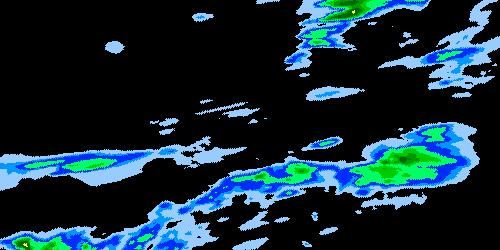

In [18]:
width = 500
height = 250

# Querying the WMS for a subset of our layer defined by our bounding box
response = wms.getmap(
    layers=[layer],
    format='image/jpeg',
    srs='EPSG:4326',
    bbox=bbox_wms,
    size=(width, height),
    styles=[hrdpa_style],
    time=start # here we're requesting this information for a specific time
)

# Show image
Image(response.read(), width=width, height=height)

And here is our new image! 

All this said, these images are a bit boring - we don't have any map features, or a colour bar. Making WMS queries like this with Python is a bit limited. But, if we query GeoMet for the raw data, instead of just a map image, we'll have much more freedom to create a custom map. Let's try this using GeoMet's Web Coverage Service (WCS).

## Manipulating current precipitation using GeoMet's Web Coverage Service

Just like we did above for the WMS, we'll start by creating an object, `wcs` that will allow us to connect to the WCS. 

In [19]:
# @title Creating a connection to the WCS

# Create a connector object to query the Web Map Service
wcs = WebCoverageService(
    f'https://geo.weather.gc.ca/geomet?&SERVICE=WCS&COVERAGEID',
    version='2.0.1',
    timeout=300
)

Fortunately, making WCS queries is very similar to making WMS queries. Let's try a query using the same parameters we specifed for our WMS queries. This time, we won't use the `Image` function to generate a map. Instead, we'll store the requested information in a dataset object.

In [20]:
# @title Making a coverage query

response = wcs.getCoverage(
    identifier=[layer],
    format='image/netcdf',
    subsettingcrs='EPSG:4326', # note the small differences in parameter names between the WMS and WCS
    subsets=bbox_wcs, # note the small differences in parameter names between the WMS and WCS 
)

# Read data into a dataset object
ds = xr.open_dataset(response.read()).load()
ds

<xarray.Dataset>
Dimensions:  (lat: 1222, lon: 2500)
Coordinates:
  * lat      (lat) float64 29.29 29.32 29.35 29.39 ... 70.76 70.79 70.83 70.86
  * lon      (lon) float64 -151.1 -151.0 -151.0 -151.0 ... -47.79 -47.75 -47.7
Data variables:
    crs      |S1 b''
    Band1    (lat, lon) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes:
    GDAL_TIFFTAG_RESOLUTIONUNIT:  2
    GDAL_TIFFTAG_XRESOLUTION:     72.0
    GDAL_TIFFTAG_YRESOLUTION:     72.0
    Conventions:                  CF-1.5
    GDAL:                         GDAL 3.5.2, released 2022/09/02
    history:                      Sat Jun 15 18:36:34 2024: GDAL CreateCopy( ...

Now let's generate a custom plot. Note that by default the plotting code is hidden. For the purpose of this tutorial the details of the plotting code aren't important other than to know that we have much more flexibility to manipulate information from GeoMet if we grab the raw data. If you're curious you can use the arrow to the left of the code block to reveal the plotting code. 

And again, just like the code here, your FEWS system fetches raw data from the MSC servers and uses code to create custom visuals.

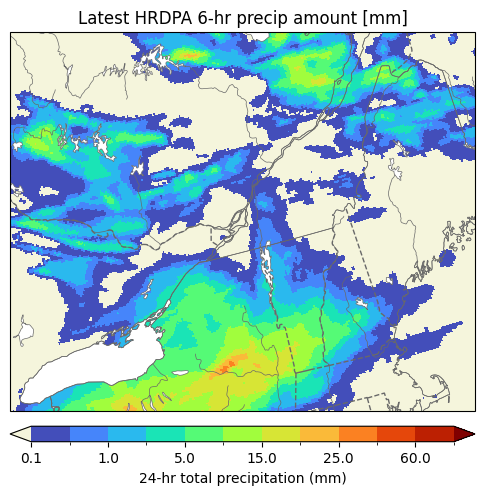

In [23]:
#@title Plot: 6h precipitation amounts from HRDPA

# Create custom colour-map for the HDRPA precip data
min_precip = 0
max_precip = 90
interval = 30

# more granularity for smaller precip accumulations
lower_levels = [0.1, 0.5, 1, 2.5, 5, 10, 15, 20, 25]
# less granularity for the larger precip accumulations
upper_levels = list(range(30, max_precip+interval, interval))

levels = lower_levels + upper_levels

cmap = plt.get_cmap("turbo").copy() # copy an existing color-map
cmap.set_over("maroon") # set the colour for the maximum level
cmap.set_under("beige") # set the colour for the minimum level

# Create figure box
fig = plt.figure(figsize=(6,8))

# Specify coordinate reference system that the data will be projected to
projection = ccrs.LambertConformal()
ax = plt.axes(projection=projection)

west, south, east, north = bbox_wms
ax.set_extent([west, east, south, north])

# Add HRDPA data to map

x = ds['Band1']['lon']
y = ds['Band1']['lat']

mesh = ax.pcolormesh(
    x, y, ds['Band1'],
    transform=ccrs.PlateCarree(),
    cmap=cmap,
    norm=mcolors.BoundaryNorm(levels, ncolors=256, extend='both'),
    label='none',
    shading='auto'
)

# Add geographic features to map

edgecolor = 'dimgrey'
linewidth = 0.5

# Physical features
ax.add_feature(cf.COASTLINE, edgecolor=edgecolor, linewidth=linewidth)
ax.add_feature(cf.LAND, edgecolor=edgecolor, facecolor="beige", linewidth=linewidth)
rivers = cf.NaturalEarthFeature(
    category='physical',
    name='rivers_lake_centerlines',
    scale='10m',
    linewidth=0.5,
    edgecolor=edgecolor,
    facecolor='none',
)
ax.add_feature(rivers)
ax.add_feature(cf.LAKES, facecolor='white', edgecolor=edgecolor, linewidth=linewidth)

# Country borders
countries = cf.NaturalEarthFeature(
    category='cultural',
    name='admin_0_countries_lakes',
    scale='10m',
    edgecolor=edgecolor,
    facecolor='none',
    linewidth=linewidth
)
ax.add_feature(countries)

# Province and Territory borders
borders = cf.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='10m',
    edgecolor=edgecolor,
    facecolor='none'
)
ax.add_feature(borders, linestyle='dashed')

# Add colorbar as separate axis and make it the right size
cb = fig.colorbar(
    mesh,
    location='bottom',
    shrink=1.0,
    pad=0.025,
    fraction=0.05,
    aspect=30,
    label='6-hr total precipitation (mm)'
)
# cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
# cb.cax.set_yticklabels(["{:.0f}".format(i) if i >= 1 else "{:.1f}".format(i) for i in cb.get_ticks()])

# Add a plot title
ax.set_title(
      f"Latest HRDPA 6-hr precip amount [mm]"
  );

Now our map image looks more interesting!

Just like with our first WMS query, we didn't specify any time information so our map was created using the latest analysis issue. Let's take a look to see what a WCS query looks like when we specify the time information. First, we'll load our time metadata from the WMS again.

**Note: the metadata and time information for a given GeoMet layer is only available from the WMS. If you want to only make WCS queries, you will still need to create a `wms` object to look for the necessary metadata and time information.

In [24]:
# Recall that metadata (including time info) comes from the WMS:
# time_info = wms[layer].dimensions['time']

start, end, issue_interval = time_info['values'][0].split('/')
print(f"First query-able time: {start}")
print(f"End of query window: {end}")
print(f"Interval that queries can be made: {issue_interval[-3:]}")

First query-able time: 2024-05-15T00:00:00Z
End of query window: 2024-06-15T06:00:00Z
Interval that queries can be made: T6H


Rather than querying for a specific issue time and making the same static map image again, let's query for multiple issue times and create a map animation. First, we'll use the time `values` to construct a list of all available analysis issue times. 

In [25]:
first_time = start
last_time = end

iso_format = "%Y-%m-%dT%H:%M:%SZ"

# Convert date strings to datetime objects
first = datetime.strptime(first_time, iso_format)
last = datetime.strptime(last_time, iso_format)

# Remove anything that isn't a number from the datetime interval (time between issues)
intvl = int(re.sub(r'\D', '', issue_interval))

# Create a list of forecast datetimes
hrs = [first]
while first < last:
  first = first + timedelta(hours=intvl)
  hrs.append(first)

# create a list of ISO formatted datetime strings
analysis_hrs = [datetime.strftime(hr, iso_format) for hr in hrs if hr < last]

Now, we'll step through our list of available issue times and make a query for each time. Note that we need to make separate queries to GeoMet for each issue time. In other words, we can't make a query to GeoMet to return multiple layers at once.

Depending on our WiFi speed, this next code block may take a minute or two to run. Let's run the code block and pause for questions while we wait for our queries to finish.

In [108]:
# @title Querying for multiple predictions
arrys = []

for i in range(len(analysis_hrs)):

    clear_output(wait=True)
    display(f"Querying for layer at time {analysis_hrs[i]}")

    response = wcs.getCoverage(
        identifier=[layer],
        format='image/netcdf',
        subsettingcrs='EPSG:4326',
        subsets=bbox_wcs,
        TIME=analysis_hrs[i]
    )

    # read into an xarray
    ds = xr.open_dataset(response.read()).load()

    # add the time metadata as a new dimension and coordinate
    da = ds.expand_dims(time=[datetime.strptime(analysis_hrs[i], iso_format)])

    # append to list of xarrays
    arrys.append(da)

fcasts = xr.concat([ds for ds in arrys], dim='time')

'Querying for layer at time 2024-06-15T00:00:00Z'

Finally, we're ready to create our animation. Just like above, the details of this code are hidden for simplicity. This code might also take a few minutes to finish and in the interest of time, we'll only animate a few layers (issue times).

In [33]:
#@title Animation: 6h precipitation amounts from HRDPA
# Create figure box
gs = GridSpec(1, 2, width_ratios = [0.9, 0.05])
fig = plt.figure(figsize = (7, 7))

# fig.subplots_adjust(left=0, bottom=0, right=1, top=1)

# Specify coordinate reference system that the data will be projected to
projection = ccrs.LambertConformal()
ax = fig.add_subplot(gs[0], projection=projection)
cbar_ax = fig.add_subplot(gs[1])

# shrink the colorbar so that it has the same height as the plot
b = cbar_ax.get_position()
new_h = b.height*0.75
pad = (b.height-new_h)/2.
new_y0 = b.y0 + pad
new_y1 = b.y1 - pad
b.y0 = new_y0
b.y1 = new_y1
cbar_ax.set_position(b)

west, south, east, north = bbox_wms
ax.set_extent([west, east, south, north])

x = fcasts['Band1']['lon']
y = fcasts['Band1']['lat']

# Add geographic features to map

edgecolor = 'dimgrey'

# Physical features
ax.add_feature(cf.COASTLINE, edgecolor=edgecolor)
ax.add_feature(cf.LAND, edgecolor=edgecolor, facecolor="beige")
rivers = cf.NaturalEarthFeature(
    category='physical',
    name='rivers_lake_centerlines',
    scale='10m',
    linewidth=0.5,
    edgecolor=edgecolor,
    facecolor='none',
)
ax.add_feature(rivers)
ax.add_feature(cf.LAKES, facecolor='white', edgecolor=edgecolor)

# Country borders
countries = cf.NaturalEarthFeature(
    category='cultural',
    name='admin_0_countries_lakes',
    scale='10m',
    edgecolor=edgecolor,
    facecolor='none'
)
ax.add_feature(countries)

# Province and Territory borders
borders = cf.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='10m',
    edgecolor=edgecolor,
    facecolor='none'
)
ax.add_feature(borders, linestyle='dashed')

mesh = ax.pcolormesh(
      x, y, fcasts['Band1'].sel(time=hrs[0]),
      transform=ccrs.PlateCarree(),
      cmap=cmap, norm=mcolors.BoundaryNorm(levels, ncolors=256, extend='both'),
      label='none', shading='auto'
  )
cbar_ax.set_yticklabels(["{:.0f}".format(i) if i >= 1 else "{:.1f}".format(i) for i in cb.get_ticks()])
fig.colorbar(mesh, cax=cbar_ax, ticks=levels, label='6-hr total precipitation (mm)')


def update_map(i):
  mesh = ax.pcolormesh(
      x, y, fcasts['Band1'].sel(time=hrs[i]),
      transform=ccrs.PlateCarree(),
      cmap=cmap, norm=mcolors.BoundaryNorm(levels, ncolors=256, extend='both'),
      label='none', shading='auto'
  )
  ax.set_title(
      f"HRDPA 6-hr precip amount [mm] valid for {analysis_hrs[i]} UTC"
  )

anim = FuncAnimation(fig, update_map, frames=8, interval=600, repeat=False)
plt.close()
anim

And there you have it! We've finished running through the basics of the WMS and WCS APIs. We've seen how we can use the WMS to retrieve metadata and generate simple map images to give us a "first look" at GeoMet layers. And we've seen how we can manipulate and customize info from GeoMet by retrieving the raw data from the WCS. We've also learned that the code here is analogous to the functionality of your FEWS system that retrieves data from the MSC. 

To round out this tutorial, we'll have a quick look at GeoMet's newer APIs.

## Viewing forecasted precipitation using GeoMet's OGC-Features API

The Web Map and Web Coverage services are GeoMet's mature geospatial web services, but more recently, GeoMet has offered data from a suite of newer services, the OGC APIs. In this tutorial, we'll explore the OGC-Features API. The goal for this next section will be to compare the HRDPA precipitation amounts we retrieved from the WCS earlier with observed precipitation amounts from a climate station close to the location of interest that we specified at the beginning of this tutorial. We'll use the OGC-Features API to grab the precipiation observations.

If your original location didn't have much going on in terms of precipitation, you can change the coordinates in the box below.

In [110]:
# Lat / Lon coords for place of interest
lat = 45.48
lon = -73.79

buffer = 1.0

# Bounding box for the Web Map Service
bbox_oafeat = (lon-buffer, lat-buffer*0.5, lon+buffer, lat+buffer*0.5)

To start let's create a OGC-Features API connection, which we'll call `oafeat`. Next, we'll make two queries. First, we'll query the collection of climate stations to find a station that has real-time data. Then, we'll use the climate station ID to request data from the station. Unlike, the WMS and WCS, both the metadata and data are available via the OGC-Features API. Another bonus of the OGC-Features API is that we can preview the available data and explore its metadata in our browser. This makes it easier to find the query information.

In [35]:
# @title Creating a connection to the OGC-Features API and making a query

oafeat = Features("https://api.weather.gc.ca/")

# Make a query for climate station metadata
stations = oafeat.collection_items(
    'climate-stations', # here we're specifying that we'll query the collection of climate stations
    bbox=bbox_oafeat,
    HAS_HOURLY_DATA='Y' # we'll filter the query so that we only see stations with hourly data
)

Let's store the information from the Features API in a table.

In [38]:
station_table = gpd.GeoDataFrame.from_features(stations['features'])
station_table.head(10)

,geometry,STN_ID,STATION_NAME,PROV_STATE_TERR_CODE,ENG_PROV_NAME,FRE_PROV_NAME,COUNTRY,LATITUDE,LONGITUDE,TIMEZONE,...,LAST_DATE,HLY_FIRST_DATE,HLY_LAST_DATE,DLY_FIRST_DATE,DLY_LAST_DATE,MLY_FIRST_DATE,MLY_LAST_DATE,HAS_MONTHLY_SUMMARY,HAS_NORMALS_DATA,HAS_HOURLY_DATA
0,POINT (-73.75000 45.46667),5415,MONTREAL/PIERRE ELLIOTT TRUDEAU INTL A,QC,QUEBEC,QUÉBEC,CAN,452800000,-734500000,EST,...,2013-02-14 13:00:00,1953-01-01 00:00:00,2013-02-14 13:00:00,1941-09-01 00:00:00,2013-02-13 00:00:00,1941-01-01 00:00:00,2013-02-01 00:00:00,N,Y,Y
1,POINT (-74.03333 45.66667),5616,MONTREAL/MIRABEL INT'L A,QC,QUEBEC,QUÉBEC,CAN,454000000,-740200000,EST,...,2012-09-13 13:00:00,1975-10-01 00:00:00,2012-09-13 13:00:00,1975-10-01 00:00:00,2008-11-30 00:00:00,1975-01-01 00:00:00,2008-11-01 00:00:00,Y,Y,Y
2,POINT (-73.74083 45.47056),51157,MONTREAL INTL A,QC,QUEBEC,QUÉBEC,CAN,452814000,-734427000,EST,...,2024-06-13 12:30:01,2013-02-13 10:00:00,2024-06-13 12:30:01,2013-02-14 00:00:00,2024-06-13 00:00:00,None,None,Y,N,Y
3,POINT (-73.43472 45.80944),5237,L'ASSOMPTION,QC,QUEBEC,QUÉBEC,CAN,454834000,-732605000,EST,...,2024-06-13 12:30:01,1994-09-07 08:00:00,2024-06-13 12:30:01,1930-01-01 00:00:00,2024-06-13 00:00:00,1930-01-01 00:00:00,1994-12-01 00:00:00,Y,N,Y
4,POINT (-73.41667 45.51667),5490,MONTREAL/ST-HUBERT A,QC,QUEBEC,QUÉBEC,CAN,453100000,-732500000,EST,...,2015-03-31 00:00:00,1953-01-01 00:00:00,2005-01-21 08:00:00,1928-08-01 00:00:00,2015-03-31 00:00:00,1928-01-01 00:00:00,2015-03-01 00:00:00,Y,Y,Y
5,POINT (-73.67889 45.16722),10762,STE-CLOTILDE,QC,QUEBEC,QUÉBEC,CAN,451002000,-734044000,EST,...,2024-06-13 12:30:01,1994-02-01 02:00:00,2024-06-13 12:30:01,1993-08-31 00:00:00,2024-06-13 00:00:00,None,None,Y,N,Y
6,POINT (-73.34944 45.29389),10843,L'ACADIE,QC,QUEBEC,QUÉBEC,CAN,451738000,-732058000,EST,...,2024-06-13 12:30:01,1994-02-01 02:00:00,2024-06-13 12:30:01,1994-07-06 00:00:00,2024-06-13 00:00:00,None,None,Y,N,Y
7,POINT (-74.03861 45.68056),49608,MONTREAL MIRABEL INTL A,QC,QUEBEC,QUÉBEC,CAN,454050000,-740219000,EST,...,2024-06-13 12:30:01,2012-09-13 14:00:00,2024-06-13 12:30:01,2018-10-30 00:00:00,2024-06-13 00:00:00,None,None,Y,N,Y
8,POINT (-73.74167 45.46778),30165,MONTREAL/PIERRE ELLIOTT TRUDEAU INTL,QC,QUEBEC,QUÉBEC,CAN,452804000,-734430000,EST,...,2024-06-13 12:30:01,2008-01-08 13:00:00,2024-06-13 12:30:01,2002-12-23 00:00:00,2024-06-13 00:00:00,None,None,Y,N,Y
9,POINT (-73.41667 45.51667),30170,MONTREAL/ST-HUBERT A,QC,QUEBEC,QUÉBEC,CAN,453100000,-732500000,EST,...,2010-02-23 08:10:00,2004-04-07 04:00:00,2010-02-23 08:10:00,2005-01-01 00:00:00,2010-02-21 00:00:00,2005-01-01 00:00:00,2010-01-01 00:00:00,Y,N,Y


Using the information from the table above, pick a station with real-time data and enter its station ID into the code block below as the variable `stn_id`.

In [39]:
stn_id = 30165

# We'll grab data as far back as the first available analysis time until the latest available time
start = start 
end = station_table['HLY_LAST_DATE'].loc[station_table['STN_ID'] == stn_id]

# Filter the table so that we remove all unneeded stations
stn = station_table.loc[station_table['STN_ID'] == stn_id]

# Pull out the station latitude and longitude
stn_lon = stn['geometry'].x.values[0]
stn_lat = stn['geometry'].y.values[0]

In [76]:
# Make a query for data from a climate station
weather = oafeat.collection_items(
    'climate-hourly', # now we're querying the hourly climate data collection
    bbox=bbox_oafeat,
    STN_ID=stn_id, # we'll filter our query by our station of interest
    datetime=f"{start}/{end}" # and we'll filter by our specified time period
)
# again, we'll store this information in a table
weather_table = gpd.GeoDataFrame.from_features(weather['features'])
weather_table.head()

,geometry,STATION_PRESSURE,HUMIDEX_FLAG,STATION_NAME,HUMIDEX,TEMP_FLAG,PRECIP_AMOUNT,PRECIP_AMOUNT_FLAG,STATION_PRESSURE_FLAG,WEATHER_FRE_DESC,...,LOCAL_DAY,UTC_YEAR,WINDCHILL,LOCAL_YEAR,WINDCHILL_FLAG,UTC_DAY,WIND_SPEED_FLAG,LOCAL_DATE,WIND_DIRECTION,PROVINCE_CODE
0,POINT (-73.74167 45.46778),100.50,None,MONTREAL/PIERRE ELLIOTT TRUDEAU INTL,NaN,None,0.0,None,None,ND,...,29,2024,None,2024,None,29,None,2024-05-29 00:00:00,33,QC
1,POINT (-73.74167 45.46778),100.54,None,MONTREAL/PIERRE ELLIOTT TRUDEAU INTL,NaN,None,0.0,None,None,ND,...,29,2024,None,2024,None,29,None,2024-05-29 01:00:00,30,QC
2,POINT (-73.74167 45.46778),100.61,None,MONTREAL/PIERRE ELLIOTT TRUDEAU INTL,NaN,None,0.0,None,None,ND,...,29,2024,None,2024,None,29,None,2024-05-29 02:00:00,31,QC
3,POINT (-73.74167 45.46778),100.66,None,MONTREAL/PIERRE ELLIOTT TRUDEAU INTL,NaN,None,0.0,None,None,ND,...,29,2024,None,2024,None,29,None,2024-05-29 03:00:00,31,QC
4,POINT (-73.74167 45.46778),100.70,None,MONTREAL/PIERRE ELLIOTT TRUDEAU INTL,NaN,None,0.0,None,None,ND,...,29,2024,None,2024,None,29,None,2024-05-29 04:00:00,32,QC


In [114]:
# Sanity check that this station is recording precipitation
weather_table['PRECIP_AMOUNT'].sum()

66.6

Now that we've fetched our precipitation observations, we'll clean up our data table to make manipulating and plotting the data easier.

In [131]:
# Remove all columns aside from the time and precip amount
precip = weather_table[['UTC_DATE', 'PRECIP_AMOUNT']]

# Rename the columns for nice plot titles
precip = precip.rename(columns={'UTC_DATE': 'Time', 'PRECIP_AMOUNT': 'Observations'})

# Index our table by time so that we can put our data in the proper order
precip = precip.set_index('Time')
precip.index = pd.to_datetime(precip.index)
precip.sort_index(inplace=True)

Since we want to compare the precipitation observations with the data from HRDPA, we will need to compute the observed 6-hr accumulations.

In [132]:
# Aggregate the hourly precipitation amounts over 6-hour intervals
precip = precip.resample(rule='6H', closed='right', label='right').sum()

In [139]:
# Print the stop of the precipitation table to take a peak at the data
precip.head()

,Observations,HRDPA,RDPA,Cumulative Observations,Cumulative HRDPA,Cumulative RDPA
Time,,,,,,
2024-05-17 06:00:00,0.0,0.066800,0.007625,0.0,0.066800,0.007625
2024-05-17 12:00:00,0.0,0.009500,0.009500,0.0,0.076300,0.017125
2024-05-17 18:00:00,0.6,0.095400,0.003875,0.6,0.171700,0.021000
2024-05-18 00:00:00,0.0,0.000000,0.000000,0.6,0.171700,0.021000
2024-05-18 06:00:00,0.0,0.017125,0.007750,0.6,0.188825,0.028750


Let's query for the HRDPA data again from the WCS just in case the available times changed or if we changed our location of interest. Let's also query for data from the Regional Deterministic Precipitation Analysis (RDPA) to add to our comparison. Since we've seen this code above, we've hidden it here for simplicity.

In [ ]:
# @title Querying for model data for comparison
buffer = 5
bbox_wcs = [('lat', lat-buffer, lat+buffer), ('lon', lon-buffer, lon+buffer)]

arrys = []

for i in range(len(analysis_hrs)):

    clear_output(wait=True)
    display(f"Querying for HRDPA layer at time {analysis_hrs[i]}")

    response = wcs.getCoverage(
        identifier=['HRDPA.6F_PR'],
        format='image/netcdf',
        subsettingcrs='EPSG:4326',
        subsets=bbox_wcs,
        TIME=analysis_hrs[i]
    )

    # read into an xarray
    ds = xr.open_dataset(response.read()).load()

    # add the time metadata as a new dimension and coordinate
    da = ds.expand_dims(time=[datetime.strptime(analysis_hrs[i], iso_format)])

    # append to list of xarrays
    arrys.append(da)

hrdpa_fcasts = xr.concat([ds for ds in arrys], dim='time')

arrys = []

for i in range(len(analysis_hrs)):

    clear_output(wait=True)
    display(f"Querying for RDPA layer at time {analysis_hrs[i]}")

    response = wcs.getCoverage(
        identifier=['RDPA.6F_PR'],
        format='image/netcdf',
        subsettingcrs='EPSG:4326',
        subsets=bbox_wcs,
        TIME=analysis_hrs[i]
    )

    # read into an xarray
    ds = xr.open_dataset(response.read()).load()

    # add the time metadata as a new dimension and coordinate
    da = ds.expand_dims(time=[datetime.strptime(analysis_hrs[i], iso_format)])

    # append to list of xarrays
    arrys.append(da)

rdpa_fcasts = xr.concat([ds for ds in arrys], dim='time')

'Querying for HRDPA layer at time 2024-06-09T18:00:00Z'

Just like we cleaned up the observations, we'll also clean up the analysis data. Importantly, when we query a layer from GeoMet, it is returned to us with a generic name, `Band1`. We'll want to change the `Band1` name so we can differentiate the HRDPA and RDPA data.

In [122]:
# Select only the grid cell that contains or is closest to our climate station
hrdpa = hrdpa_fcasts.sel(lat=stn_lat, lon=stn_lon, method='nearest')
# Move the HRDPA data into a dataframe
hrdpa = hrdpa.to_dataframe().drop(columns=['lat', 'lon', 'crs'])
# Rename the `Band1` column to something more prescriptive
hrdpa = hrdpa.rename(columns={'time': 'Time', 'Band1': 'HRDPA'})
hrdpa.head()

,HRDPA
time,
2024-05-15 00:00:00,0.026750
2024-05-15 06:00:00,0.343250
2024-05-15 12:00:00,2.214375
2024-05-15 18:00:00,0.030500
2024-05-16 00:00:00,0.080000


In [128]:
# We'll do the same cleanup with the RDPA data
rdpa = rdpa_fcasts.sel(lat=stn_lat, lon=stn_lon, method='nearest')
rdpa = rdpa.to_dataframe().drop(columns=['lat', 'lon', 'crs'])
rdpa = rdpa.rename(columns={'time': 'Time', 'Band1': 'RDPA'})
rdpa.head()

,RDPA
time,
2024-05-15 00:00:00,0.001900
2024-05-15 06:00:00,0.171700
2024-05-15 12:00:00,0.778250
2024-05-15 18:00:00,0.042000
2024-05-16 00:00:00,0.001875


Now that our data cleanup is finished, we can merge the observed and analysis data into one table.

In [134]:
# Combine the HRDPA, RDPA, and observed precip data into one table
precip = precip.join(hrdpa)
precip = precip.join(rdpa)
precip.head()

,Observations,HRDPA,RDPA
Time,,,
2024-05-17 06:00:00,0.0,0.066800,0.007625
2024-05-17 12:00:00,0.0,0.009500,0.009500
2024-05-17 18:00:00,0.6,0.095400,0.003875
2024-05-18 00:00:00,0.0,0.000000,0.000000
2024-05-18 06:00:00,0.0,0.017125,0.007750


Let's also take the cumulative sum of the precipitation amounts over the whole period so that we can visualize the data in a couple of different ways.

In [135]:
# Compute the cumulative precipitation amounts for each precip time series
precip['Cumulative Observations'] = precip['Observations'].cumsum()
precip['Cumulative HRDPA'] = precip['HRDPA'].cumsum()
precip['Cumulative RDPA'] = precip['RDPA'].cumsum()

Finally, let's plot a time series of 6-hour precipitation amounts and let's create a small table to the right of the plot so we can explore the data values. How well does the prediction and observed data compare? 

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
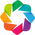

:Layout
   .NdOverlay.I :NdOverlay   [Variable]
      :Curve   [Time]   (6-hr Precipitation amounts (mm))
   .Table.I     :Table   [Time,Observations,HRDPA,RDPA]

In [136]:
(precip.hvplot.step(x='Time', y=['Observations', 'HRDPA', 'RDPA'], value_label='6-hr Precipitation amounts (mm)') +
 precip.hvplot.table(['Time', 'Observations', 'HRDPA', 'RDPA']))

We can compare the observed data and prediction data in another way by looking at the cumulative amounts over the entire period.

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
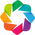

:Layout
   .NdOverlay.I :NdOverlay   [Variable]
      :Curve   [Time]   (Cumulative precipitation (mm))
   .Table.I     :Table   [Time,Cumulative Observations,Cumulative HRDPA,Cumulative RDPA]

In [137]:
(precip.hvplot.step(x='Time', y=['Cumulative Observations', 'Cumulative HRDPA', 'Cumulative RDPA'], value_label='Cumulative precipitation (mm)') +
 precip.hvplot.table(['Time', 'Cumulative Observations', 'Cumulative HRDPA', 'Cumulative RDPA']))

And that's a wrap! In this section we learned how queries are made to the newer GeoMet API, OGC-Features. We saw that the mechanics of the queries were similar to the way we query the WMS and WCS, but that the Features API provides more convenient ways to explore the data and associated metadata. Note that hydrometric observations are available via GeoMet using the OGC-Features API.

## Summary

Overall, this tutorial provides a brief technical overview of retrieving prediction data from the MSC's GeoMet. While the mechanics of querying for data from GeoMet appear straightforward here, we still need a fair amount of requisite knowledge and coding ability to make requests and manipulate the prediction information. A data management system like FEWS removes or lessens these technical requirements. Notwithstanding, tutorials like these can help FEWS users and others become generally familiar with the way data is retrieved from GeoMet and they can provide helpful background information for technical discussions with industry partners. Also, for FEWS users who would like a hand in managing or adding to their FEWS configuration, tutorials like these can provide a gentle introduction to the various GeoMet APIs and point users to associated documentation.